# Backtesting
### Price
Use ``price`` to get the current price of a symbol. Given a number, it will go back that amount of days, which can be used to compute averages, etc.
### Available Capital & Capital
While ``capital`` is the current value of your portfolio + cash, ``available_capital`` is capital not tied up in securities only.
### Order
Use ``order`` to enter a long trade of the given ticker, using the given funds (either use an absolute number or a percentage when passing ``as_percent=True``). To enter a short position, pass ``short=True``.
### Portfolio
``portfolio`` is a dataframe that contains information about all currently held positions.
### Liquidate
Use ``liquidate`` to get out of positions. Simply pass a filter for ``portfolio`` and all entries matching it will be liquidated.

In [1]:
from simple_back.backtester import BacktesterBuilder
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

## Iterator
The backtester object can be iterated over to run simple strategies.
It exposes ``day`` (e.g. 2010-01-01), ``event`` ('open' or 'close') and itself.

In [2]:
ticker = 'QQQ'
bt = BacktesterBuilder().balance(1_000_000).calendar('NYSE').build()

for day, event, b in bt['2011-06-01':'2012-04-02']:
    # calculate average price of the ticker over the last 30 days
    avg_open = b.prices[ticker,-30:]['open'].mean()
    
    if day == date(2011,6,1) and event == 'open':
        b.order_abs('ETR', b.price('ETR')*261)
        
    if day == date(2011,10,3) and event == 'open':
        b.order_abs('ETR', b.price('ETR')*86.1)

In [3]:
bt.portfolio[bt.pf['profit_loss_pct'] <= 0.03]

  symbol        date event order_type  profit_loss_abs  profit_loss_pct  \
0    ETR  2011-06-01  open       long       354.277458         0.029939   

       price  
0  46.695461  

In [3]:
ticker = '^GSPC'

class Monthly:
    def __init__(self):
        self.last_month = None
        
    def __call__(self, day, event, bt):
        if day.month != self.last_month:
            self.last_month = day.month
            try:
                bt.order_abs(ticker, bt.balance.start / 12)
            except Exception as e:
                pass
            
class NDayLow:
    def __init__(self, n_days):
        self.n_days=n_days
        self.n_days_since=None
        
    def __call__(self, day, event, bt):
        if event == 'open':
            if self.n_days_since is not None:
                self.n_days_since += 1
        if (bt.price(ticker)<bt.prices[ticker,-(self.n_days+1):-1]).all().all():
            try:
                if self.n_days_since is None or self.n_days_since > 30:
                    bt.order_abs(ticker, bt.balance.start / 12)
                    self.n_days_since = 0
            except:
                pass
        
bt = BacktesterBuilder().balance(12_0000).calendar('NYSE').live_metrics().build()
bts = bt[-relativedelta(years=10):].run([Monthly(),NDayLow(50)])

Max Drawdown         -19230.84      -16194.39      
Annual Return        1.09           1.07           
Portfolio Value      282302.96      237728.81      
Total Value          289705.08      246214.42      
Profit/Loss          1708.12        1438.42        


In [10]:
bts[1].metrics['Portfolio Value'].df

,open,close
date,,
2017-05-30,0.000000,964.232697
2017-05-31,967.643812,963.891647
2017-06-01,965.869913,967.643616
2017-06-02,971.054817,978.695618
2017-06-05,978.627331,978.490860
...,...,...
2020-05-22,1599.149979,1607.620026
2020-05-26,1633.520004,1603.279953
2020-05-27,1600.830017,1612.029953


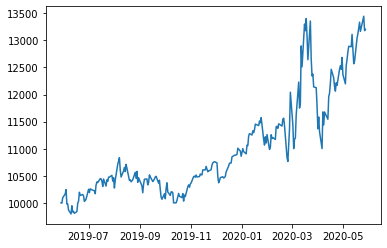

In [8]:
plt.plot(bt.metrics['Total Value'].df['open'])

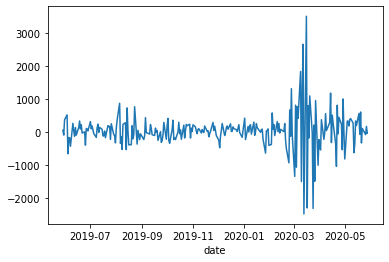

In [5]:
bt.metrics['Profit/Loss'].df.sum(axis=1).plot()